# Evaluation of Neural Networks

## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

In [1]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

### A few key notes regarding [Sequential Models](https://www.tensorflow.org/guide/keras/sequential_model):

In [2]:
#Setup
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### When to Use a Sequential Model

A `Sequential` model is appropriate for **a plain stack of layers** where each layer has **exactly one input tensor and one output tensor**.

Schematically, this `Sequential` model:
```
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
# Call model on a test input
x = tf.ones((3, 3))
y = model(x)

```

...is equivalent to this function:
```
# Create 3 layers
layer1 = layers.Dense(2, activation="relu", name="layer1")
layer2 = layers.Dense(3, activation="relu", name="layer2")
layer3 = layers.Dense(4, name="layer3")

# Call layers on a test input
x = tf.ones((3, 3))
y = layer3(layer2(layer1(x)))
```

A Sequential model is **not** appropriate when:

- Your model has multiple inputs or multiple outputs
- Any of your layers has multiple inputs or multiple outputs
- You need to do layer sharing
- You want non-linear topology (e.g. a residual connection, a multi-branch model)

Let's demonstrate a few more concepts

In [3]:
model = keras.Sequential()
model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(3, activation="relu"))
model.add(layers.Dense(4))

We can view the layers added to the model

In [4]:
model.layers

Generally, all layers in Keras need to know the shape of their inputs in order to be able to create their weights. So when you create a layer like this, initially, it has no weights:

In [5]:
# This will throw an error

model.weights

ValueError: Weights for model sequential have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

In [6]:
# This will throw an error:

model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

**Note**: *The model creates its weights the first time it is called on an input, since the shape of the weights depends on the shape of the inputs.*

In [7]:
x = tf.ones((1, 4))
y = model(x)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  10        
_________________________________________________________________
dense_1 (Dense)              multiple                  9         
_________________________________________________________________
dense_2 (Dense)              multiple                  16        
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


2023-02-10 11:55:46.574034: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 11:55:46.577130: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.


In [9]:
x

<tf.Tensor: id=3, shape=(1, 4), dtype=float32, numpy=array([[1., 1., 1., 1.]], dtype=float32)>

In [8]:
model.weights

[<tf.Variable 'sequential/dense/kernel:0' shape=(4, 2) dtype=float32, numpy=
 array([[-0.6902063 , -0.23596334],
        [-0.94185615, -0.7988186 ],
        [ 0.20027065,  0.9933746 ],
        [-0.3131261 ,  0.7467599 ]], dtype=float32)>,
 <tf.Variable 'sequential/dense/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,
 <tf.Variable 'sequential/dense_1/kernel:0' shape=(2, 3) dtype=float32, numpy=
 array([[ 0.65952766, -0.952578  , -1.0125351 ],
        [-0.16158265,  0.66973126, -0.49983495]], dtype=float32)>,
 <tf.Variable 'sequential/dense_1/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'sequential/dense_2/kernel:0' shape=(3, 4) dtype=float32, numpy=
 array([[ 0.04865986, -0.4937047 , -0.500952  , -0.5393034 ],
        [-0.33507514,  0.11549067, -0.68966657, -0.23820943],
        [-0.46704328,  0.08719277,  0.56330657,  0.61173224]],
       dtype=float32)>,
 <tf.Variable 'sequential/dense_2/bias:0' shape=(4,) dtype=f

It can be helpful to note that there's also a corresponding `pop()` method to remove layers; a `Sequential` model behaves very much like a list of layers:

In [10]:
model.pop()

In [11]:
model.layers

And of course, we can still add layers to our Sequential model

In [12]:
model.add(layers.Dense(4))

In [13]:
model.layers

### From last time

In [14]:
digits = load_digits()
X = digits.data
y = digits.target

y_binary = y % 2

In [16]:
type(y_binary)

numpy.ndarray

In [17]:
y_binary

array([0, 1, 0, ..., 0, 1, 0])

In [15]:
#Set up, compile, and fit a simple neural network model.

model = Sequential()

#Here, we implicitly define our input layer.
#Alternatively, we could have instantiated our model as
#model = Sequential([tf.keras.layers.InputLayer(input_shape=(64,))]
model.add(Dense(12, activation='relu', input_dim=64))

model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Train on 1797 samples
Epoch 1/50
1797/1797 [==============================] - 1s 646us/sample - loss: 0.7315 - accuracy: 0.6656
Epoch 2/50
1797/1797 [==============================] - 0s 148us/sample - loss: 0.3158 - accuracy: 0.8625
Epoch 3/50
1797/1797 [==============================] - 0s 137us/sample - loss: 0.2292 - accuracy: 0.9071
Epoch 4/50
1797/1797 [==============================] - 0s 131us/sample - loss: 0.1880 - accuracy: 0.9238
Epoch 5/50
1797/1797 [==============================] - 0s 151us/sample - loss: 0.1614 - accuracy: 0.9310
Epoch 6/50
1797/1797 [==============================] - 0s 133us/sample - loss: 0.1335 - accuracy: 0.9449
Epoch 7/50
1797/1797 [==============================] - 0s 157us/sample - loss: 0.1150 - accuracy: 0.9533
Epoch 8/50
1797/1797 [==============================] - 0s 151us/sample - loss: 0.1055 - accuracy: 0.9566
Epoch 9/50
1797/1797 [==============================] - 0s 147us/sample - loss: 0.1010 - accuracy: 0.9594
Epoch 10/50
1797/1797 [=

It is generally recommended to use the Keras Functional model via an input_dim parameter, which creates an InputLayer, without directly using InputLayer

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [18]:
#Perform preprocessing to set up our data arrays appropriately
X_train, X_test, y_train, y_test =\
train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [19]:
#First Model

model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign to a variable to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Train on 1149 samples
Epoch 1/10
1149/1149 [==============================] - 0s 359us/sample - loss: 0.8295 - accuracy: 0.5039
Epoch 2/10
1149/1149 [==============================] - 0s 16us/sample - loss: 0.8068 - accuracy: 0.5039
Epoch 3/10
1149/1149 [==============================] - 0s 21us/sample - loss: 0.7885 - accuracy: 0.5039
Epoch 4/10
1149/1149 [==============================] - 0s 18us/sample - loss: 0.7730 - accuracy: 0.5039
Epoch 5/10
1149/1149 [==============================] - 0s 21us/sample - loss: 0.7595 - accuracy: 0.5039
Epoch 6/10
1149/1149 [==============================] - 0s 16us/sample - loss: 0.7487 - accuracy: 0.5039
Epoch 7/10
1149/1149 [==============================] - 0s 20us/sample - loss: 0.7398 - accuracy: 0.5039
Epoch 8/10
1149/1149 [==============================] - 0s 19us/sample - loss: 0.7323 - accuracy: 0.5039
Epoch 9/10
1149/1149 [==============================] - 0s 18us/sample - loss: 0.7262 - accuracy: 0.5039
Epoch 10/10
1149/1149 [=========

We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [20]:
results.history

{'loss': [0.8294714534147809,
  0.8068252838726558,
  0.7885241524046457,
  0.7729907222578482,
  0.7595320652110147,
  0.7486889190109426,
  0.7398484551045457,
  0.7322715280157676,
  0.7262081025578438,
  0.7211136270648402],
 'accuracy': [0.50391644,
  0.50391644,
  0.50391644,
  0.50391644,
  0.50391644,
  0.50391644,
  0.50391644,
  0.50391644,
  0.50391644,
  0.50391644]}

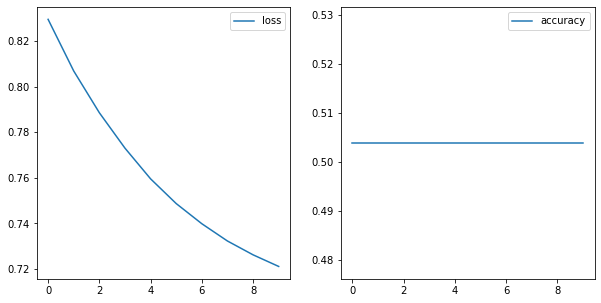

In [21]:
#Get the loss function values, and the accuracy values
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [22]:
X_pure_train.shape[0]

1149

In [23]:
#Second model: Make the changes noted above.

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=None, verbose=1)


Train on 1149 samples
Epoch 1/100
1149/1149 [==============================] - 1s 513us/sample - loss: 0.7478 - accuracy: 0.4595
Epoch 2/100
1149/1149 [==============================] - 0s 43us/sample - loss: 0.6973 - accuracy: 0.5205
Epoch 3/100
1149/1149 [==============================] - 0s 42us/sample - loss: 0.6804 - accuracy: 0.5674
Epoch 4/100
1149/1149 [==============================] - 0s 41us/sample - loss: 0.6690 - accuracy: 0.6084
Epoch 5/100
1149/1149 [==============================] - 0s 43us/sample - loss: 0.6587 - accuracy: 0.6371
Epoch 6/100
1149/1149 [==============================] - 0s 53us/sample - loss: 0.6480 - accuracy: 0.6667
Epoch 7/100
1149/1149 [==============================] - 0s 46us/sample - loss: 0.6360 - accuracy: 0.6858
Epoch 8/100
1149/1149 [==============================] - 0s 44us/sample - loss: 0.6220 - accuracy: 0.7032
Epoch 9/100
1149/1149 [==============================] - 0s 50us/sample - loss: 0.6051 - accuracy: 0.7276
Epoch 10/100
1149/1149 

1149/1149 [==============================] - 0s 43us/sample - loss: 0.1633 - accuracy: 0.9234
Epoch 78/100
1149/1149 [==============================] - 0s 41us/sample - loss: 0.1614 - accuracy: 0.9234
Epoch 79/100
1149/1149 [==============================] - 0s 38us/sample - loss: 0.1613 - accuracy: 0.9260
Epoch 80/100
1149/1149 [==============================] - 0s 39us/sample - loss: 0.1597 - accuracy: 0.9243
Epoch 81/100
1149/1149 [==============================] - 0s 48us/sample - loss: 0.1592 - accuracy: 0.9269
Epoch 82/100
1149/1149 [==============================] - 0s 44us/sample - loss: 0.1580 - accuracy: 0.9286
Epoch 83/100
1149/1149 [==============================] - 0s 42us/sample - loss: 0.1569 - accuracy: 0.9286
Epoch 84/100
1149/1149 [==============================] - 0s 38us/sample - loss: 0.1562 - accuracy: 0.9243
Epoch 85/100
1149/1149 [==============================] - 0s 41us/sample - loss: 0.1539 - accuracy: 0.9260
Epoch 86/100
1149/1149 [==========================

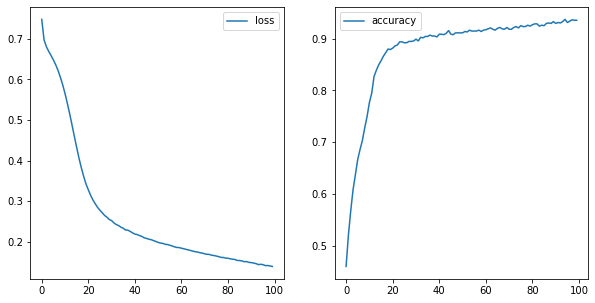

In [24]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Train on 1149 samples
Epoch 1/30
1149/1149 [==============================] - 1s 476us/sample - loss: 22.6552 - accuracy: 0.5030
Epoch 2/30
1149/1149 [==============================] - 0s 120us/sample - loss: 1.0059 - accuracy: 0.4865
Epoch 3/30
1149/1149 [==============================] - 0s 150us/sample - loss: 1.1241 - accuracy: 0.4830
Epoch 4/30
1149/1149 [==============================] - 0s 146us/sample - loss: 1.0319 - accuracy: 0.5109
Epoch 5/30
1149/1149 [==============================] - 0s 131us/sample - loss: 0.9434 - accuracy: 0.5030
Epoch 6/30
1149/1149 [==============================] - 0s 138us/sample - loss: 1.0563 - accuracy: 0.4743
Epoch 7/30
1149/1149 [==============================] - 0s 138us/sample - loss: 0.9337 - accuracy: 0.5065
Epoch 8/30
1149/1149 [==============================] - 0s 122us/sample - loss: 1.1324 - accuracy: 0.4778
Epoch 9/30
1149/1149 [==============================] - 0s 117us/sample - loss: 0.9736 - accuracy: 0.5030
Epoch 10/30
1149/1149 [

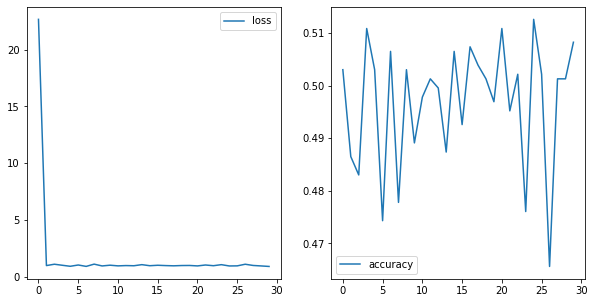

In [25]:
model = Sequential()

sgd = SGD(lr=9) #Setting a really high learning rate
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

In [26]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## YOUR CODE STARTING HERE
results = model.fit(X_pure_train, y_pure_train, epochs=30, batch_size=10, validation_data=(X_val, y_val) )

Train on 1149 samples, validate on 288 samples
Epoch 1/30
1149/1149 [==============================] - 1s 938us/sample - loss: 0.6242 - accuracy: 0.6945 - val_loss: 0.5122 - val_accuracy: 0.8264
Epoch 2/30
1149/1149 [==============================] - 0s 189us/sample - loss: 0.3535 - accuracy: 0.8721 - val_loss: 0.2861 - val_accuracy: 0.8889
Epoch 3/30
1149/1149 [==============================] - 0s 182us/sample - loss: 0.2583 - accuracy: 0.8982 - val_loss: 0.2526 - val_accuracy: 0.8924
Epoch 4/30
1149/1149 [==============================] - 0s 182us/sample - loss: 0.2196 - accuracy: 0.9112 - val_loss: 0.2270 - val_accuracy: 0.9132
Epoch 5/30
1149/1149 [==============================] - 0s 181us/sample - loss: 0.1912 - accuracy: 0.9173 - val_loss: 0.1925 - val_accuracy: 0.9132
Epoch 6/30
1149/1149 [==============================] - 0s 184us/sample - loss: 0.1695 - accuracy: 0.9234 - val_loss: 0.1749 - val_accuracy: 0.9201
Epoch 7/30
1149/1149 [==============================] - 0s 183us/

In [27]:
results.history

{'loss': [0.6242083739051619,
  0.35354561555816155,
  0.2583392782313498,
  0.21960177698907798,
  0.19116059811323804,
  0.16950367258179178,
  0.15662250554495474,
  0.1401132360883738,
  0.12762056057016366,
  0.12218268932020851,
  0.10822696229840124,
  0.099192377299012,
  0.10029851842316612,
  0.09730355113864697,
  0.08862553624634034,
  0.08235636695484275,
  0.07434941886934744,
  0.07259016389988146,
  0.06632256386331481,
  0.06079039467702108,
  0.0653963591089858,
  0.05906233967663242,
  0.05731629456371738,
  0.04862274788413785,
  0.0459391339395057,
  0.04228471422278597,
  0.03724551819727105,
  0.03408548015676799,
  0.033289614869668686,
  0.035406245606937434],
 'accuracy': [0.69451696,
  0.8720627,
  0.8981723,
  0.91122717,
  0.9173194,
  0.92341167,
  0.9321149,
  0.9321149,
  0.9442994,
  0.9416884,
  0.9495213,
  0.9538729,
  0.9564839,
  0.95474327,
  0.95474327,
  0.96692777,
  0.97214967,
  0.9765013,
  0.9808529,
  0.98172325,
  0.9765013,
  0.9808529,


Train on 1149 samples, validate on 288 samples
Epoch 1/30
1149/1149 [==============================] - 1s 738us/sample - loss: 0.6842 - accuracy: 0.5640 - val_loss: 0.6552 - val_accuracy: 0.6354
Epoch 2/30
1149/1149 [==============================] - 0s 224us/sample - loss: 0.4218 - accuracy: 0.8442 - val_loss: 0.2995 - val_accuracy: 0.8958
Epoch 3/30
1149/1149 [==============================] - 0s 178us/sample - loss: 0.2712 - accuracy: 0.8947 - val_loss: 0.2398 - val_accuracy: 0.9097
Epoch 4/30
1149/1149 [==============================] - 0s 196us/sample - loss: 0.2344 - accuracy: 0.9069 - val_loss: 0.2169 - val_accuracy: 0.9271
Epoch 5/30
1149/1149 [==============================] - 0s 193us/sample - loss: 0.2063 - accuracy: 0.9164 - val_loss: 0.1966 - val_accuracy: 0.9306
Epoch 6/30
1149/1149 [==============================] - 0s 180us/sample - loss: 0.1879 - accuracy: 0.9234 - val_loss: 0.2155 - val_accuracy: 0.9132
Epoch 7/30
1149/1149 [==============================] - 0s 184us/

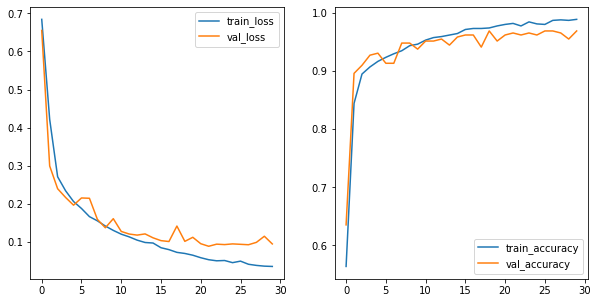

In [28]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## YOUR CODE STARTING HERE
results = model.fit(X_pure_train, y_pure_train, epochs=30, batch_size=10, validation_data=(X_val, y_val) )

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [ ]:
results.history['val_accuracy'][-1]

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [30]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fe68c88f850> does not.

In [34]:
type(model)

tensorflow.python.keras.engine.sequential.Sequential

We will now wrap our keras model as a Scikit-Learn estimator

In [31]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [32]:
#Create a Scikit-learn estimator
keras_model = scikit_learn.KerasClassifier(build_fn = build_model, epochs=50, batch_size=32, verbose=2)

In [33]:
type(keras_model)

tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier

Now we can use sklearn methods like cross_val_score

In [35]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

Train on 919 samples
Epoch 1/50
919/919 - 1s - loss: 0.6817 - accuracy: 0.5060
Epoch 2/50
919/919 - 0s - loss: 0.6574 - accuracy: 0.6268
Epoch 3/50
919/919 - 0s - loss: 0.6169 - accuracy: 0.6605
Epoch 4/50
919/919 - 0s - loss: 0.5547 - accuracy: 0.7922
Epoch 5/50
919/919 - 0s - loss: 0.4735 - accuracy: 0.8400
Epoch 6/50
919/919 - 0s - loss: 0.3862 - accuracy: 0.8694
Epoch 7/50
919/919 - 0s - loss: 0.3244 - accuracy: 0.8836
Epoch 8/50
919/919 - 0s - loss: 0.2815 - accuracy: 0.8999
Epoch 9/50
919/919 - 0s - loss: 0.2589 - accuracy: 0.8988
Epoch 10/50
919/919 - 0s - loss: 0.2288 - accuracy: 0.9140
Epoch 11/50
919/919 - 0s - loss: 0.2044 - accuracy: 0.9195
Epoch 12/50
919/919 - 0s - loss: 0.1902 - accuracy: 0.9271
Epoch 13/50
919/919 - 0s - loss: 0.1718 - accuracy: 0.9282
Epoch 14/50
919/919 - 0s - loss: 0.1589 - accuracy: 0.9347
Epoch 15/50
919/919 - 0s - loss: 0.1547 - accuracy: 0.9347
Epoch 16/50
919/919 - 0s - loss: 0.1402 - accuracy: 0.9391
Epoch 17/50
919/919 - 0s - loss: 0.1336 - ac

Epoch 38/50
919/919 - 0s - loss: 0.1793 - accuracy: 0.9859
Epoch 39/50
919/919 - 0s - loss: 0.1736 - accuracy: 0.9891
Epoch 40/50
919/919 - 0s - loss: 0.1745 - accuracy: 0.9848
Epoch 41/50
919/919 - 0s - loss: 0.1671 - accuracy: 0.9880
Epoch 42/50
919/919 - 0s - loss: 0.1635 - accuracy: 0.9891
Epoch 43/50
919/919 - 0s - loss: 0.1603 - accuracy: 0.9891
Epoch 44/50
919/919 - 0s - loss: 0.1553 - accuracy: 0.9924
Epoch 45/50
919/919 - 0s - loss: 0.1515 - accuracy: 0.9924
Epoch 46/50
919/919 - 0s - loss: 0.1502 - accuracy: 0.9902
Epoch 47/50
919/919 - 0s - loss: 0.1460 - accuracy: 0.9902
Epoch 48/50
919/919 - 0s - loss: 0.1427 - accuracy: 0.9924
Epoch 49/50
919/919 - 0s - loss: 0.1396 - accuracy: 0.9935
Epoch 50/50
919/919 - 0s - loss: 0.1385 - accuracy: 0.9924
230/1 - 0s - loss: 0.1848 - accuracy: 0.9739
Train on 919 samples
Epoch 1/50
919/919 - 1s - loss: 0.6779 - accuracy: 0.5462
Epoch 2/50
919/919 - 0s - loss: 0.6332 - accuracy: 0.6257
Epoch 3/50
919/919 - 0s - loss: 0.5782 - accuracy: 

array([0.93043476, 0.96956521, 0.97391301, 0.94782609, 0.93449783])

## Level Up: Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)


Stay tuned for next lecture where we'll talk about regularization in the context of neural networks.